In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn import set_config

pd.set_option('display.max_colwidth', None)
set_config(transform_output='pandas')
# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
# Then Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

In [2]:
df=pd.read_csv('spooky.csv',index_col=0)
df.head()

,text,author
id,,
id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP
id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL
id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",EAP
id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",MWS
id12958,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",HPL


In [3]:
# Let's take a look at the length of the each text
df['sequence_length'] =df['text'].map(lambda x: len(x.split(" ")))
df.head()

,text,author,sequence_length
id,,,
id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP,41
id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL,14
id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",EAP,36
id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",MWS,34
id12958,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",HPL,27


In [4]:
df['sequence_length'].describe()

count    19579.000000
mean        26.730477
std         19.048353
min          2.000000
25%         15.000000
50%         23.000000
75%         34.000000
max        861.000000
Name: sequence_length, dtype: float64

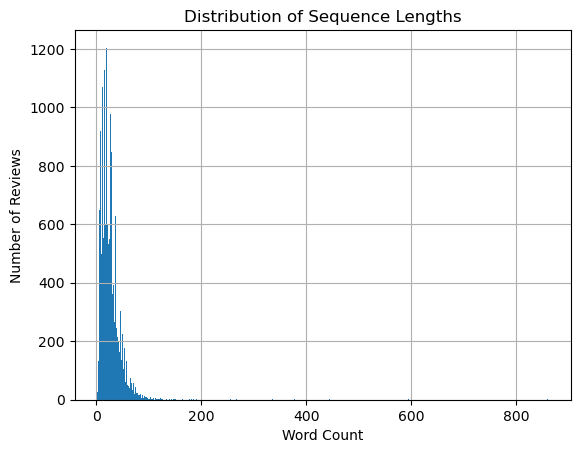

In [5]:
# Make histogram of sequence lengths
ax = df['sequence_length'].hist(bins = 'auto')
ax.set_xlabel('Word Count')
ax.set_ylabel('Number of Reviews')
ax.set_title('Distribution of Sequence Lengths');

In [6]:
# Define a filter to identify reviews less than 100 words
filter_short = df['sequence_length']< 100
print(f'Number of reviews >100 words is: {len(df) - filter_short.sum()}')

Number of reviews >100 words is: 91


In [7]:
# Keep short reviews (< 100 words)
df= df[filter_short]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19488 entries, id26305 to id00393
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             19488 non-null  object
 1   author           19488 non-null  object
 2   sequence_length  19488 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 609.0+ KB


In [8]:
df['author'].value_counts(normalize = True)

EAP    0.402966
MWS    0.308344
HPL    0.288690
Name: author, dtype: float64

In [9]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder

# Define target y
y_string= df['author']
# Instantiate the LabelEncoder
encoder = LabelEncoder()
# Fit and Transform the strings into integers
y = pd.Series(encoder.fit_transform(y_string))
y.value_counts()

0    7853
2    6009
1    5626
dtype: int64

In [10]:
# Use the RandomUnderSampler to balance the data 
sampler = RandomUnderSampler(random_state=42)
df_under, y_under = sampler.fit_resample(df, y)
y_under.value_counts()

0    5626
1    5626
2    5626
dtype: int64

In [11]:
# Define classes variable
classes = y.unique()
# Define X
X_under = df_under['text']
X_under.head()

id
id00755    The revolution itself must, of course, have taken place in an easy and gradual manner, and it is by no means clear that, had I even been awake at the time of the occurrence, I should have been made aware of it by any internal evidence of an inversion that is to say, by any inconvenience or disarrangement, either about my person or about my apparatus.
id16262                                                                                                                                                                                                                                                                            The windows, both of the back and front room, were down and firmly fastened from within.
id06592                                                                                                                                                                                                                                                                      

In [12]:
# Convert to Dataset Object
ds = tf.data.Dataset.from_tensor_slices((X_under, y_under))

# Shuffle dataset
ds = ds.shuffle(buffer_size=len(ds),reshuffle_each_iteration=False) 

In [13]:
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )
# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)

# Set the batch size
BATCH_SIZE =32

import math
# math.ceil will round up
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)

print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")

    - train:	11814 samples 	(370 batches)
    - val:  	3375 samples 	(106 batches)
    - test: 	1689 samples 	(53 batches)


In [14]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)
# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)
# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

In [15]:
# Comparing the len gths of all 3 splits
len(train_ds), len(val_ds), len(test_ds)

(370, 106, 53)

In [16]:
# display a sample single element (A single element now contains 32 samples since we set batch_size to 32)
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

tf.Tensor(
[b'There was no chance of hearing anything farther that evening in regard to Brevet Brigadier General John A. B. C. Smith.'
 b'Thus situated, my only resource was to drive before the wind.'
 b'"Hear, O ye inhabitants of the earth," he cried, "hear thou, all seeing, but most pitiless Heaven hear thou too, O tempest tossed heart, which breathes out these words, yet faints beneath their meaning Death is among us The earth is beautiful and flower bedecked, but she is our grave The clouds of heaven weep for us the pageantry of the stars is but our funeral torchlight.'
 b'Perhaps in unremembered dreams tonight; perhaps in some other form an aeon hence, when the solar system shall have been swept away."'
 b'body knew, was an unknown quantity; but in this case as he properly observed, there was an unknown quantity of X.'
 b'Prompted by some preserving instinct of self defence, I broke through the spell that had hitherto held me immovable, and flung my now dying torch at the creature

# Build a text vectorization layer to create integer sequences of each text

In [17]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)
SEQUENCE_LENGTH = 100
# Create text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH)

sequence_vectorizer.adapt(ds_texts)

In [18]:
# Programmatically define size of vocab from vectorization layer
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

20583

In [19]:
# Getting list of vocab
vocab = sequence_vectorizer.get_vocabulary()
int_to_str = {idx: word for idx, word in enumerate(vocab)}
int_to_str

{0: '',
 1: '[UNK]',
 2: 'the',
 3: 'of',
 4: 'and',
 5: 'to',
 6: 'i',
 7: 'a',
 8: 'in',
 9: 'was',
 10: 'that',
 11: 'my',
 12: 'it',
 13: 'had',
 14: 'he',
 15: 'with',
 16: 'his',
 17: 'as',
 18: 'for',
 19: 'but',
 20: 'not',
 21: 'which',
 22: 'at',
 23: 'me',
 24: 'from',
 25: 'by',
 26: 'on',
 27: 'this',
 28: 'is',
 29: 'be',
 30: 'her',
 31: 'were',
 32: 'all',
 33: 'have',
 34: 'you',
 35: 'an',
 36: 'we',
 37: 'or',
 38: 'no',
 39: 'him',
 40: 'one',
 41: 'when',
 42: 'so',
 43: 'they',
 44: 'been',
 45: 'could',
 46: 'she',
 47: 'there',
 48: 'its',
 49: 'upon',
 50: 'would',
 51: 'their',
 52: 'now',
 53: 'more',
 54: 'some',
 55: 'what',
 56: 'our',
 57: 'very',
 58: 'into',
 59: 'only',
 60: 'if',
 61: 'are',
 62: 'than',
 63: 'who',
 64: 'will',
 65: 'them',
 66: 'then',
 67: 'up',
 68: 'before',
 69: 'did',
 70: 'these',
 71: 'man',
 72: 'time',
 73: 'out',
 74: 'yet',
 75: 'even',
 76: 'said',
 77: 'about',
 78: 'any',
 79: 'might',
 80: 'after',
 81: 'old',
 82: 'y

In [20]:
# What term corresponds to 3000?
int_to_str[3000]

'bank'

In [21]:
# Obtain the sequence of sample text with the sequence_vectorizer
sequence= sequence_vectorizer(['And now he was equally resentful of awaking, for he had found his fabulous city after forty weary years.'])
sequence

<tf.Tensor: shape=(1, 100), dtype=int64, numpy=
array([[   4,   52,   14,    9, 1726, 7666,    3, 5953,   18,   14,   13,
         104,   16, 3194,  222,   80, 1520, 2232,  149,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int64)>

# build and compile a simple LSTM model

In [22]:
from tensorflow.keras import layers, models, optimizers, regularizers
# Defining an embedding layer
EMBED_DIM=150
embedding_layer = layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)

In [23]:
def build_lstm_model():
    
    # Define sequential model with pre-trained vectorization layer and resultant embedding layer
    lstm_model = models.Sequential([sequence_vectorizer, embedding_layer], name='lstm')
        
    # Add LSTM layer
    lstm_model.add(layers.LSTM(128, return_sequences = True))
    lstm_model.add(layers.GlobalMaxPooling1D())
    # Add output layer
    lstm_model.add(layers.Dense(len(classes), activation='softmax'))
 
    # Compile the model
    lstm_model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    lstm_model.summary()
    return lstm_model

In [24]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

In [25]:
def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs
    
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)

In [26]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(4,8),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):

    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")

    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict



## PLOT_HISTORY FUNCTION
def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics 
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])

    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()

    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):

        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]

        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass

        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)

    # Adjust subplots and show
    fig.tight_layout()
    plt.show()

In [27]:
def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,6), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)       y_train (array, or None if using a Dataset)
        X_test (array, or Dataset)        y_test (array, or None if using a Dataset)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict

In [28]:
# Build the lstm model
rnn_model1 = build_lstm_model()

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = rnn_model1.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 100, 150)          3087450   
                                                                 
 lstm (LSTM)                 (None, 100, 128)          142848    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 3,230,685
Trainable params: 3,230,685
Non-traina

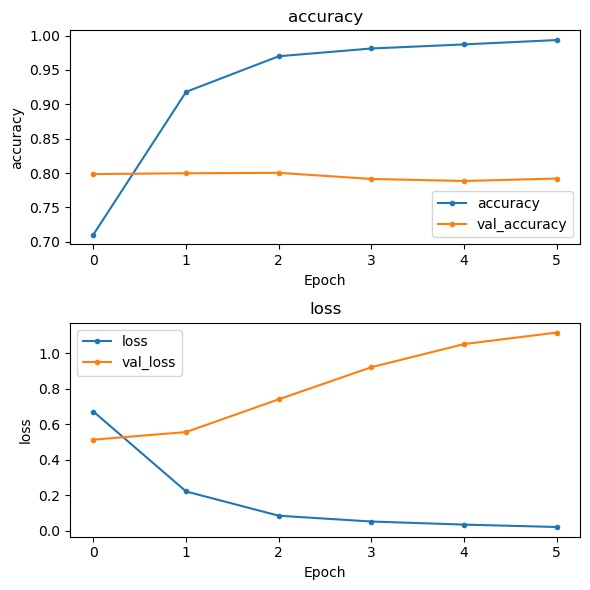


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3900
           1       1.00      1.00      1.00      3949
           2       1.00      1.00      1.00      3965

    accuracy                           1.00     11814
   macro avg       1.00      1.00      1.00     11814
weighted avg       1.00      1.00      1.00     11814



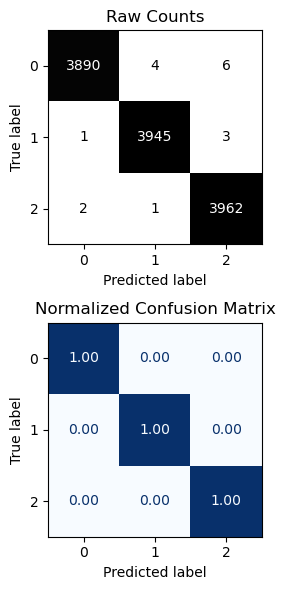


- Evaluating Training Data:
370/370 [==============================] - 12s 33ms/step - loss: 0.0057 - accuracy: 0.9986
{'loss': 0.005681750830262899, 'accuracy': 0.9985610246658325}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       573
           1       0.80      0.82      0.81       553
           2       0.78      0.85      0.81       563

    accuracy                           0.80      1689
   macro avg       0.80      0.80      0.80      1689
weighted avg       0.80      0.80      0.80      1689



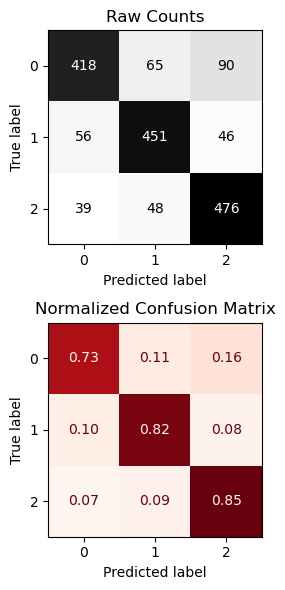


- Evaluating Test Data:
53/53 [==============================] - 2s 33ms/step - loss: 0.9918 - accuracy: 0.7963
{'loss': 0.9917880892753601, 'accuracy': 0.7963292002677917}


In [29]:
# Evaluate the model using the evaluation function
evaluate_classification_network(
    rnn_model1, X_train=train_ds, X_test=test_ds, history=history);

# build and compile a simple GRU model

In [30]:
def build_gru_model():
    
    # Define sequential model with pre-trained vectorization layer and resultant embedding layer
    gru_model = models.Sequential([sequence_vectorizer, embedding_layer], name='gru')
        
    # Add GRU layer
    gru_model.add(layers.GRU(128, return_sequences = True))
    gru_model.add(layers.GlobalMaxPooling1D())
    # Add output layer
    gru_model.add(layers.Dense(len(classes), activation='softmax'))
 
    # Compile the model
    gru_model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    gru_model.summary()
    return gru_model

In [31]:
# Build the gru model
rnn_model2 = build_gru_model()

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = rnn_model2.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

Model: "gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 100, 150)          3087450   
                                                                 
 gru (GRU)                   (None, 100, 128)          107520    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 3,195,357
Trainable params: 3,195,357
Non-trainab

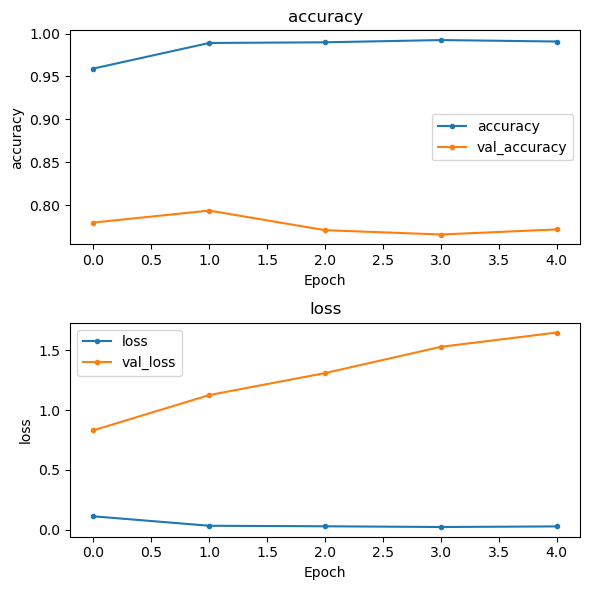


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3900
           1       1.00      0.99      1.00      3949
           2       0.99      1.00      0.99      3965

    accuracy                           0.99     11814
   macro avg       0.99      0.99      0.99     11814
weighted avg       0.99      0.99      0.99     11814



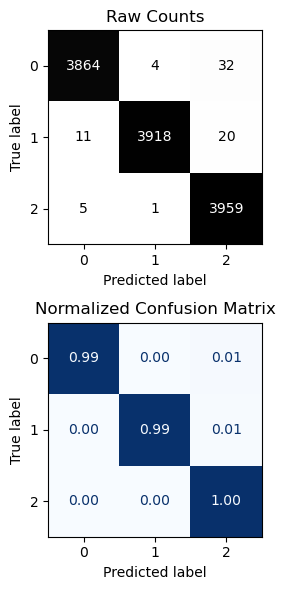


- Evaluating Training Data:
370/370 [==============================] - 10s 26ms/step - loss: 0.0179 - accuracy: 0.9938
{'loss': 0.017877962440252304, 'accuracy': 0.9938209056854248}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.72      0.75       573
           1       0.84      0.73      0.78       553
           2       0.73      0.87      0.79       563

    accuracy                           0.77      1689
   macro avg       0.78      0.77      0.77      1689
weighted avg       0.78      0.77      0.77      1689



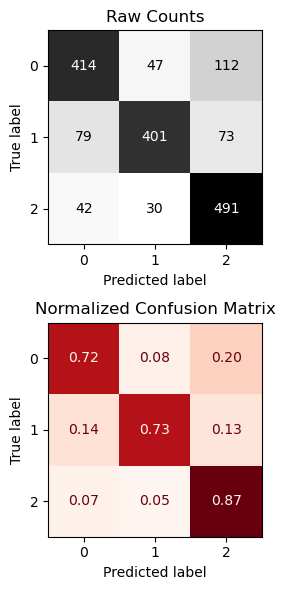


- Evaluating Test Data:
53/53 [==============================] - 2s 28ms/step - loss: 1.6104 - accuracy: 0.7732
{'loss': 1.6103724241256714, 'accuracy': 0.7732385993003845}


In [32]:
# Evaluate the model using the evaluation function
evaluate_classification_network(
    rnn_model2, X_train=train_ds, X_test=test_ds, history=history);

# We will try to improve the performance of the RNN model
- stacked RNNs
- bi-directional RNNs
- pre-trained word embeddings

In [53]:
tf.keras.backend.clear_session()
def build_hybrid_model_deep_pool():
    # Define sequential model with pre-trained vectorization layer and resultant embedding layer
    model = models.Sequential([sequence_vectorizer, embedding_layer])
        
    # Stack   
    model.add(layers.GRU(128, return_sequences=True))
    model.add(layers.Dropout(.5))  
    model.add(layers.BatchNormalization())
    # For the final layer, use return_sequences = True for pooling layer
    model.add(layers.LSTM(128, dropout=.5, return_sequences = True, kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.GlobalAveragePooling1D())
    # Add output layer
    model.add(layers.Dense(len(classes), activation='softmax'))
 
    # Compile the model
    model.compile(optimizer=optimizers.Adam(), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    model.summary()
    return model

rnn_model3 = build_hybrid_model_deep_pool()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 100, 150)          3087450   
                                                                 
 gru (GRU)                   (None, 100, 128)          107520    
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 batch_normalization (BatchN  (None, 100, 128)         512       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 100, 128)          1

In [54]:
# Fit the model
history = rnn_model3.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

Epoch 1/30
370/370 [==============================] - 161s 422ms/step - loss: 0.3955 - accuracy: 0.9543 - val_loss: 1.0064 - val_accuracy: 0.7834
Epoch 2/30
370/370 [==============================] - 162s 438ms/step - loss: 0.0290 - accuracy: 0.9954 - val_loss: 1.0642 - val_accuracy: 0.7686
Epoch 3/30
370/370 [==============================] - 162s 436ms/step - loss: 0.0287 - accuracy: 0.9958 - val_loss: 1.2318 - val_accuracy: 0.7828
Epoch 4/30
370/370 [==============================] - 200s 539ms/step - loss: 0.0130 - accuracy: 0.9979 - val_loss: 1.5427 - val_accuracy: 0.7790


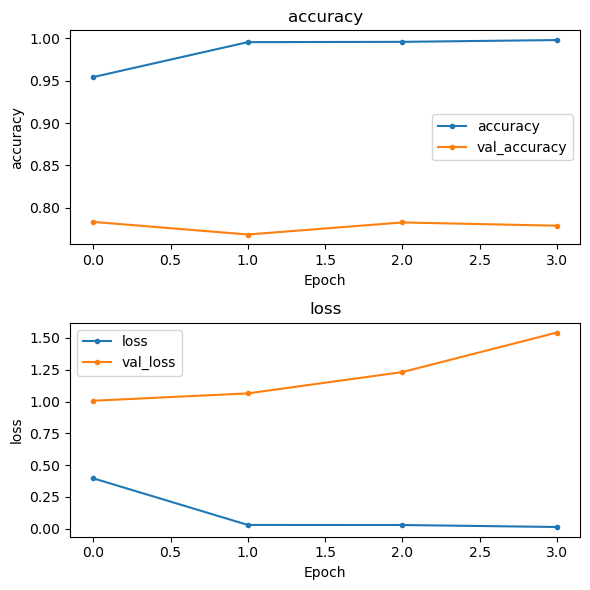


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3900
           1       1.00      1.00      1.00      3949
           2       1.00      1.00      1.00      3965

    accuracy                           1.00     11814
   macro avg       1.00      1.00      1.00     11814
weighted avg       1.00      1.00      1.00     11814



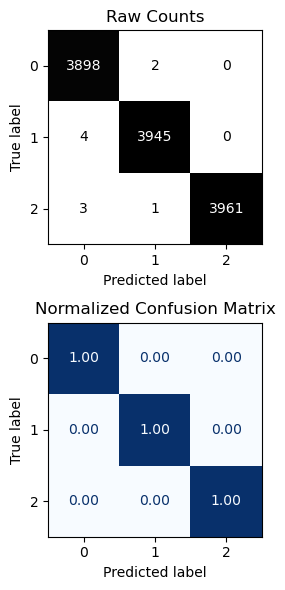


- Evaluating Training Data:
370/370 [==============================] - 35s 95ms/step - loss: 0.0096 - accuracy: 0.9992
{'loss': 0.009572314098477364, 'accuracy': 0.9991535544395447}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.79      0.77       573
           1       0.77      0.80      0.78       553
           2       0.84      0.78      0.81       563

    accuracy                           0.79      1689
   macro avg       0.79      0.79      0.79      1689
weighted avg       0.79      0.79      0.79      1689



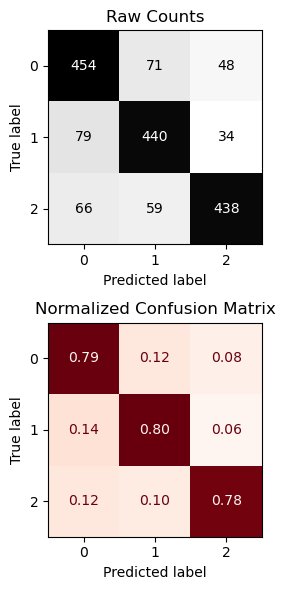


- Evaluating Test Data:
53/53 [==============================] - 5s 87ms/step - loss: 1.4900 - accuracy: 0.7886
{'loss': 1.4899595975875854, 'accuracy': 0.788632333278656}


In [55]:
# Evaluate the model using the evaluation function
evaluate_classification_network(
    rnn_model3, X_train=train_ds, X_test=test_ds, history=history);

In [36]:
tf.keras.backend.clear_session()
def build_hybrid_bi_model_deep_pool():
    # Define sequential model with pre-trained vectorization layer and resultant embedding layer
    model = models.Sequential([sequence_vectorizer, embedding_layer])
        
    # Stack   
    model.add(layers.Bidirectional(layers.GRU(64, return_sequences = True, recurrent_dropout=.2, dropout=.5)))
    # For the final layer, use return_sequences = True for pooling layer
    model.add(layers.LSTM(64, return_sequences = True)) 
    model.add(layers.GlobalMaxPooling1D())
    # Add output layer
    model.add(layers.Dense(len(classes), activation='softmax'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    model.summary()
    return model

rnn_model4 = build_hybrid_bi_model_deep_pool()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 100, 150)          3087450   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         215040    
 l)                                                              
                                                                 
 lstm (LSTM)                 (None, 100, 128)          197120    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                        

In [37]:
# Fit the model
history = rnn_model4.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

Epoch 1/30
370/370 [==============================] - 247s 650ms/step - loss: 0.0708 - accuracy: 0.9741 - val_loss: 1.0592 - val_accuracy: 0.7825
Epoch 2/30
370/370 [==============================] - 235s 635ms/step - loss: 0.0236 - accuracy: 0.9926 - val_loss: 1.2382 - val_accuracy: 0.7766
Epoch 3/30
370/370 [==============================] - 234s 634ms/step - loss: 0.0250 - accuracy: 0.9899 - val_loss: 1.1520 - val_accuracy: 0.7656
Epoch 4/30
370/370 [==============================] - 246s 664ms/step - loss: 0.0867 - accuracy: 0.9685 - val_loss: 0.9349 - val_accuracy: 0.7372


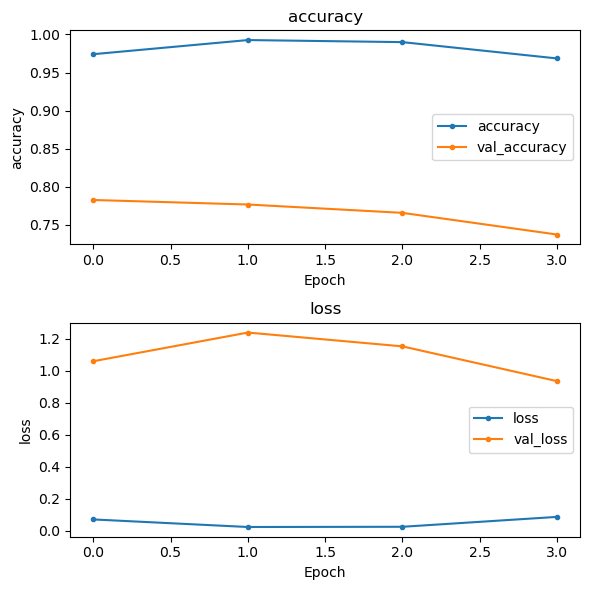


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3900
           1       0.96      0.97      0.97      3949
           2       0.98      0.95      0.96      3965

    accuracy                           0.96     11814
   macro avg       0.96      0.96      0.96     11814
weighted avg       0.96      0.96      0.96     11814



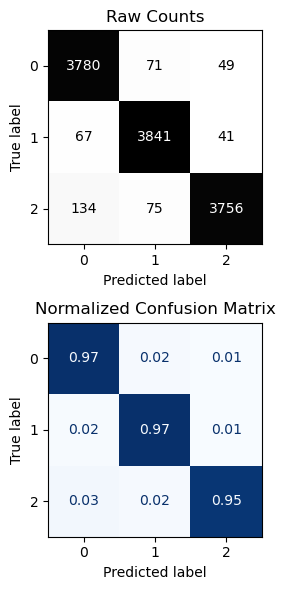


- Evaluating Training Data:
370/370 [==============================] - 38s 102ms/step - loss: 0.1002 - accuracy: 0.9629
{'loss': 0.10015358030796051, 'accuracy': 0.9629253149032593}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.72      0.73       573
           1       0.75      0.77      0.76       553
           2       0.76      0.75      0.75       563

    accuracy                           0.75      1689
   macro avg       0.75      0.75      0.75      1689
weighted avg       0.75      0.75      0.75      1689



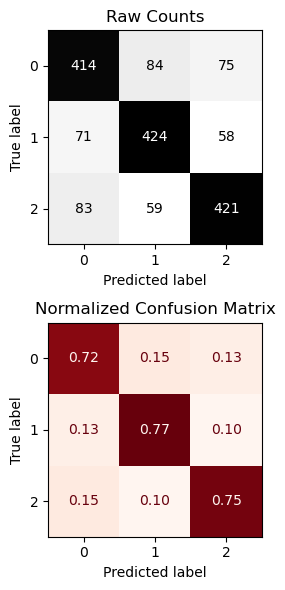


- Evaluating Test Data:
53/53 [==============================] - 6s 105ms/step - loss: 0.8812 - accuracy: 0.7454
{'loss': 0.8812289237976074, 'accuracy': 0.7454115152359009}


In [38]:
# Evaluate the model using the evaluation function
evaluate_classification_network(
    rnn_model4, X_train=train_ds, X_test=test_ds, history=history);

In [39]:
from gensim.models import KeyedVectors
# Load GloVe vectors into a gensim model
glove_model = KeyedVectors.load_word2vec_format("GloVe2/glove.6B.100d.txt", binary=False, no_header=True)

In [40]:
glove_model['king'].shape

(100,)

In [41]:
# Initialize an empty matrix the same shape as our EMbedding layer 
# to hold the word vectors from GloVe
EMBED_DIM=100
embedding_matrix = np.zeros((VOCAB_SIZE, EMBED_DIM))

In [42]:
# Can save a list of words that were not found
unmatched_vocab = []

# Loop to get each word from vocabulary and get its pre-trained vector from GloVe model
for i, word in enumerate(sequence_vectorizer.get_vocabulary()):
    try:
        embedding_matrix[i] = glove_model[word]
    except KeyError:
        # If the word is not in the GloVe vocabulary,print it
        unmatched_vocab.append(word)
        

# # Unmatched
percent_unmatched = len(unmatched_vocab)/VOCAB_SIZE*100
print(f"- {len(unmatched_vocab)} ({percent_unmatched:.2f}%) tokens not found in glove embedding")

- 1845 (8.96%) tokens not found in glove embedding


In [43]:
unmatched_vocab[:10]

['',
 '[UNK]',
 'shewed',
 'oclock',
 'iranon',
 'clerval',
 'whateleys',
 'abaout',
 'diddler',
 'daown']

In [44]:
# Create the embedding layer using the embedding matrix
# First, make a Constant initializer with the embedding matrix
initializer = tf.keras.initializers.Constant(embedding_matrix)

# Then use this initializer as the embedding_initializer argument.
glove_embedding_layer = layers.Embedding(input_dim=VOCAB_SIZE,
                            output_dim=EMBED_DIM,
                            embeddings_initializer =initializer, # Use the initializer as embeddings_initializer
                            trainable=False,   # Keeps the embeddings fixed 
                            input_length=SEQUENCE_LENGTH)

In [45]:
def build_hybrid_bi_model_glove():
    # Define sequential model with pre-trained vectorization layer and resultant embedding layer
    model = models.Sequential([sequence_vectorizer, glove_embedding_layer])
        
    # Stack   
    model.add(layers.Bidirectional(layers.GRU(128, return_sequences = True, recurrent_dropout=.3)))
    model.add(layers.GlobalAveragePooling1D())
    # Add output layer
    model.add(layers.Dense(len(classes), activation='softmax'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    model.summary()
    return model

rnn_model5 = build_hybrid_bi_model_glove()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 100, 100)          2058300   
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 256)         176640    
 nal)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 100, 128)          197120    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                      

In [46]:
# Fit the model
history = rnn_model5.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

Epoch 1/30
370/370 [==============================] - 179s 463ms/step - loss: 0.9168 - accuracy: 0.5682 - val_loss: 0.7546 - val_accuracy: 0.6794
Epoch 2/30
370/370 [==============================] - 159s 430ms/step - loss: 0.8243 - accuracy: 0.6315 - val_loss: 0.8069 - val_accuracy: 0.6373
Epoch 3/30
370/370 [==============================] - 156s 422ms/step - loss: 0.8320 - accuracy: 0.6231 - val_loss: 0.8121 - val_accuracy: 0.6430
Epoch 4/30
370/370 [==============================] - 152s 412ms/step - loss: 0.8983 - accuracy: 0.5814 - val_loss: 0.8655 - val_accuracy: 0.6089


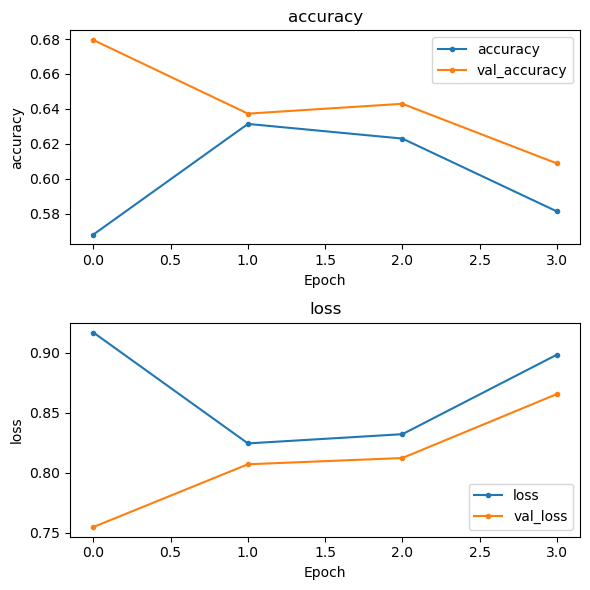


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.56      0.67      0.61      3900
           1       0.68      0.56      0.61      3949
           2       0.66      0.66      0.66      3965

    accuracy                           0.63     11814
   macro avg       0.63      0.63      0.63     11814
weighted avg       0.63      0.63      0.63     11814



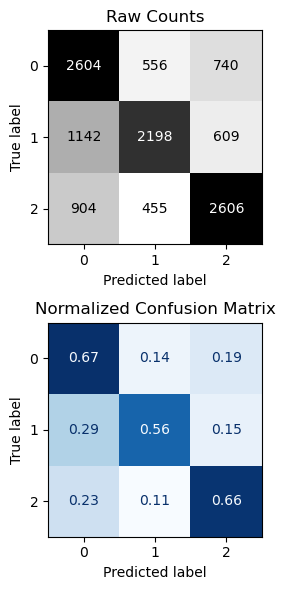


- Evaluating Training Data:
370/370 [==============================] - 33s 90ms/step - loss: 0.8403 - accuracy: 0.6271
{'loss': 0.8403292298316956, 'accuracy': 0.6270526647567749}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.55      0.67      0.60       573
           1       0.67      0.53      0.59       553
           2       0.67      0.66      0.66       563

    accuracy                           0.62      1689
   macro avg       0.63      0.62      0.62      1689
weighted avg       0.63      0.62      0.62      1689



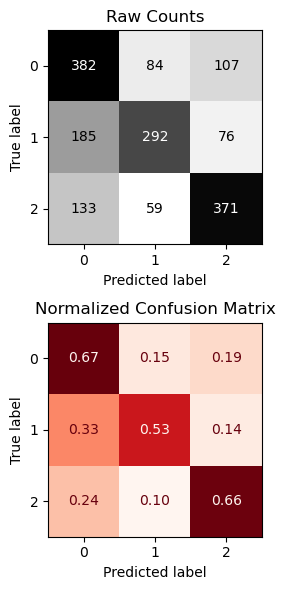


- Evaluating Test Data:
53/53 [==============================] - 5s 97ms/step - loss: 0.8569 - accuracy: 0.6187
{'loss': 0.8568748831748962, 'accuracy': 0.6187092661857605}


In [47]:
# Evaluate the model using the evaluation function
evaluate_classification_network(
    rnn_model5, X_train=train_ds, X_test=test_ds, history=history);

In [56]:
def build_stack_model_glove():
    # Define sequential model with pre-trained vectorization layer and resultant embedding layer
    model = models.Sequential([sequence_vectorizer, glove_embedding_layer])
        
    # Stack   
    model.add(layers.GRU(256, return_sequences = True, recurrent_dropout=.2, dropout=.4))
    model.add(layers.GRU(128, return_sequences = True)) 
    model.add(layers.GRU(64, return_sequences = True)) 
    model.add(layers.GlobalAveragePooling1D())
    # Add output layer
    model.add(layers.Dense(len(classes), activation='softmax'))
 
    # Compile the model
    model.compile(optimizer=optimizers.SGD(learning_rate=0.02), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    model.summary()
    return model

rnn_model6 = build_stack_model_glove()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 100, 100)          2058300   
                                                                 
 gru_1 (GRU)                 (None, 100, 256)          274944    
                                                                 
 gru_2 (GRU)                 (None, 100, 128)          148224    
                                                                 
 gru_3 (GRU)                 (None, 100, 64)           37248     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                             

In [57]:
# Fit the model
history = rnn_model6.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

Epoch 1/30
370/370 [==============================] - 343s 907ms/step - loss: 1.0925 - accuracy: 0.3919 - val_loss: 1.0870 - val_accuracy: 0.4359
Epoch 2/30
370/370 [==============================] - 364s 984ms/step - loss: 1.0779 - accuracy: 0.4520 - val_loss: 1.0689 - val_accuracy: 0.4708
Epoch 3/30
370/370 [==============================] - 329s 888ms/step - loss: 1.0521 - accuracy: 0.4840 - val_loss: 1.0518 - val_accuracy: 0.4281
Epoch 4/30
370/370 [==============================] - 264s 714ms/step - loss: 1.0181 - accuracy: 0.5102 - val_loss: 1.0841 - val_accuracy: 0.3902
Epoch 5/30
370/370 [==============================] - 269s 728ms/step - loss: 0.9911 - accuracy: 0.5266 - val_loss: 1.1204 - val_accuracy: 0.3893


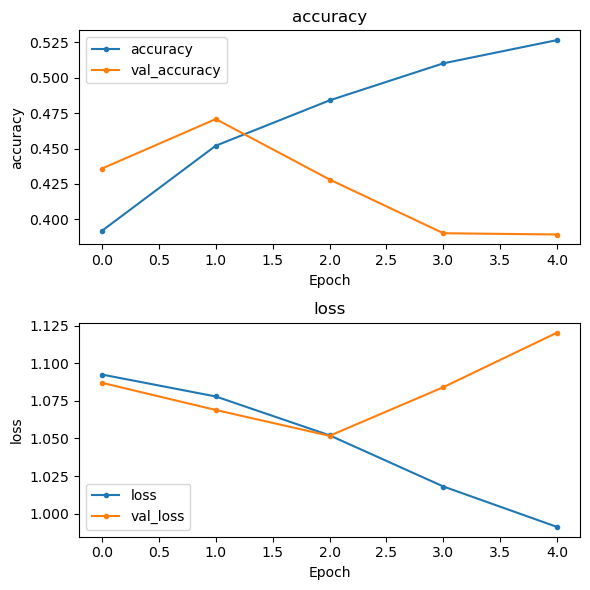


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.53      0.18      0.26      3900
           1       0.84      0.06      0.11      3949
           2       0.38      0.97      0.54      3965

    accuracy                           0.40     11814
   macro avg       0.58      0.40      0.30     11814
weighted avg       0.58      0.40      0.31     11814



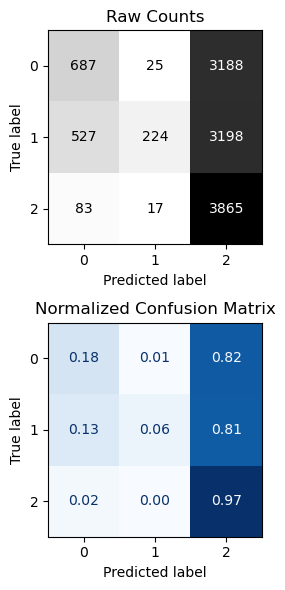


- Evaluating Training Data:
370/370 [==============================] - 83s 224ms/step - loss: 1.1041 - accuracy: 0.4043
{'loss': 1.1040624380111694, 'accuracy': 0.4042661190032959}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.56      0.21      0.30       573
           1       0.77      0.04      0.08       553
           2       0.38      0.97      0.54       563

    accuracy                           0.41      1689
   macro avg       0.57      0.41      0.31      1689
weighted avg       0.57      0.41      0.31      1689



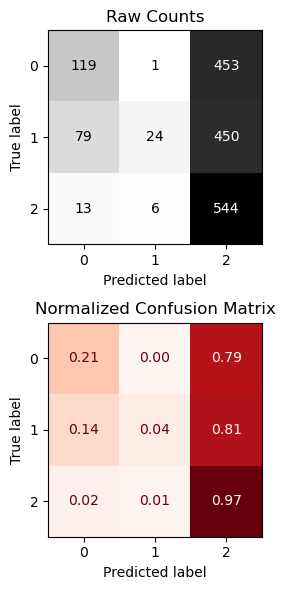


- Evaluating Test Data:
53/53 [==============================] - 11s 206ms/step - loss: 1.0917 - accuracy: 0.4067
{'loss': 1.0916986465454102, 'accuracy': 0.40674954652786255}


In [58]:
# Evaluate the model using the evaluation function
evaluate_classification_network(
    rnn_model6, X_train=train_ds, X_test=test_ds, history=history);